In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sys 
import os
import networkx as nx
from collections import Counter, defaultdict
import EoN

# define path to the project for convenoent relative import
sys.path.append(os.path.dirname(os.getcwd())) 
from source.model_output import SEIRModelOutput, SEIRParams


In [17]:
class SEIRNetworkModel():
    def __init__(self, population: int):
        self.population = population
        
        # FOLLOWING PARAMETERS ARE EPIDEMICALLY DETERMINED
        # R_0 HERE LIES IN RANGE [1; 2.5]
        self.min_params = SEIRParams(beta=1/9, gamma=1/5, delta=1/9, init_inf_frac=1e-6, init_rec_frac=1e-2)
        self.max_params = SEIRParams(beta=0.625, gamma=1, delta=1/4, init_inf_frac=1e-3, init_rec_frac=2e-1)
        self.last_sim_params = None
        
        self.G=nx.barabasi_albert_graph(population, 5)
    
    @staticmethod
    def find_nearest_idx(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
    def transform_event_times_to_days(self, model_output):
        indices = []
        for day in range(len(model_output.t)):
            index = self.find_nearest_idx(model_output.t, day)
            indices.append(index)
        new_model_output = SEIRModelOutput(model_output.t[indices], model_output.S[indices],
                                        model_output.E[indices], model_output.I[indices],
                                        model_output.R[indices])
        return new_model_output
                

    def simulate(self, beta=1/7*1.5, gamma=1/2, delta=1/7, init_inf_frac=1e-4, init_rec_frac=0.15, tmax: int = 150):
        '''
        Parameters:
        
        beta: transmission rate
        gamma: rate of progression from exposed to infectious
        delta: recovery rate
        init_inf_frac: fraction of initially infected
        init_rec_frac: fraction of initially recovered
        '''
        H = nx.DiGraph()
        H.add_edge('E', 'I', rate=gamma)
        H.add_edge('I', 'R', rate=delta)
        J = nx.DiGraph()
        J.add_edge(('I', 'S'), ('I', 'E'), rate=beta)
        initial_infected = int(init_inf_frac*self.population)
        initial_status = defaultdict(lambda: 'S')
        for node in range(initial_infected):
            initial_status[node] = 'I'
        self.result = self.transform_event_times_to_days(SEIRModelOutput\
                        (*EoN.Gillespie_simple_contagion(self.G, H, J, initial_status, \
                        return_statuses=('S', 'E', 'I', 'R'), tmax=tmax)))
        return self.result
        # self.result = SEIRModelOutput(t, S, E, I, R)
        # self.last_sim_params = SEIRParams(beta, gamma, delta, init_inf_frac, init_rec_frac)
        # return self.result

In [18]:
tmax = 180
iterations = 5  # run 5 simulations
beta = 0.01 # transmission rate
delta = 0.08 # recovery rate
init_inf_frac = 0.005 # random fraction initially infected
gamma = 0.1 # latent period rate

num_runs = 10

In [20]:
network_model = SEIRNetworkModel(10**5)
res = network_model.simulate(beta=beta, gamma=gamma, delta=delta, init_inf_frac=0.005)

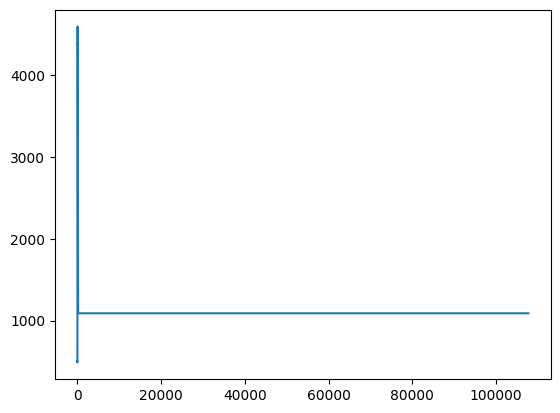

In [22]:
plt.plot(res.I)